In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from pymlx import *
import time

Load data

In [3]:
train_file = '../data/census_income.train.csv'
test_file = '../data/census_income.test.csv'
label_col = 'Income >50K'

train_df, _ = utils.load_data(train_file, label_col)
# suggested_handlers = suggest_handlers(train_df)

feat = Featurizer([
    OneHotHandler(['Native Country', 'Occupation', 'Race', 'Relationship Status', 'Sex', 'Workclass']),
    BinNormalizer(['Age', 'Capital Gain', 'Hours per week', 'Years in Education', 'Capital Loss']),
    IdEncodingHandler(['Education', 'Marital Status'])
])

Learn features

In [4]:
start_timing()
feat.learn(train_file) # in case the train data is large, the featurizer only needs to be trained on sampled data
train_features, train_labels = utils.load_featurized_data(train_file, label_col, feat, return_dataframe=False)
report_timing()

Elapsed: 0.058 minutes


Find the best params

In [7]:
import xgboost
import lightgbm

In [8]:
start_timing()
sweeper = random_sweep(
    train_features, train_labels, 
    lightgbm.LGBMClassifier(), {
                      'max_depth': [3, 5, 10, 20], 
                      'n_estimators': [10, 20, 40, 80],
                      'subsample': [1, 0.8]},
    scoring=pr_scorer, n_iter=10, verbose=1)
report_timing()

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Elapsed: 0.07 minutes


[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    4.2s finished


Training

In [10]:
start_timing()
predictor = lightgbm.LGBMClassifier(n_estimators=80, max_depth=10, subsample=0.8)
predictor.fit(train_features, train_labels) # refit the model on full data
report_timing()

# Combine featurizer and predictor to make an end-to-end model
model = BinaryClassifier(predictor, feat)

Elapsed: 0.003 minutes


Testing

In [11]:
test_df, test_labels = load_data(test_file, label_col)

In [12]:
predictions, raw = model.bulk_predict(test_df)

Result

In [13]:
confusion_matrix(test_labels, predictions)

interactive(children=(FloatSlider(value=0.5, description='threshold', max=1.0, step=0.01), Output()), _dom_cla…

Feature importance

In [23]:
import xgboost

In [24]:
a = xgboost.XGBClassifier

In [29]:
a.__module__

'xgboost.sklearn'

'lightgbm.sklearn'

In [15]:
fscores = model.get_fscores()
fscores.head(10)

Age_bin                        379
Hours_per_week_bin             258
Capital_Gain_bin               253
Capital_Loss_bin               241
Years_in_Education_bin         210
Marital_Status_ide             102
Education_ide                   86
Relationship_Status=Husband     58
Relationship_Status=Wife        53
Occupation=Exec-managerial      50
dtype: int64

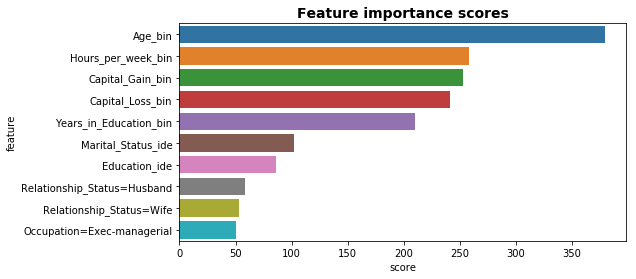

In [18]:
visualize_feature_importance(fscores.to_dict(), 10, fig_height=4)

Feature density to the target

In [19]:
features = train_features.copy()
features['Target'] = train_labels

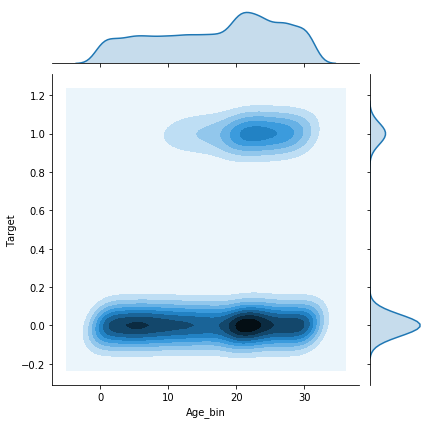

In [20]:
visualize_feat_density(features, 'Age_bin', 'Target')

In [21]:
diagnostics = diagnose(model, test_df, test_labels, predictions=predictions)
diagnostics.head(10)

,Labeled,Predicted Probability,Native Country=United-States,Native Country=Cuba,Native Country=Jamaica,Native Country=India,Native Country=?,Native Country=Mexico,Native Country=South,Native Country=Puerto-Rico,...,Workclass=Self-Emp-Inc,Workclass=Without-Pay,Workclass=Never-Worked,Age Bin,Capital Gain Bin,Hours Per Week Bin,Years In Education Bin,Capital Loss Bin,Education Ide,Marital Status Ide
7214,1,0.001424,0,0,0,0,0,0,0,0,...,0,0,0,4,0,7,3,0,11,0
149,1,0.003545,0,0,0,0,0,1,0,0,...,0,0,0,15,0,7,4,0,8,0
1492,1,0.009243,1,0,0,0,0,0,0,0,...,0,0,0,8,0,7,13,0,0,0
1681,1,0.009924,1,0,0,0,0,0,0,0,...,0,0,0,31,0,3,9,0,1,6
5306,1,0.014526,1,0,0,0,0,0,0,0,...,0,0,0,19,0,7,9,0,1,2
1027,1,0.016621,1,0,0,0,0,0,0,0,...,0,0,0,15,0,7,9,0,1,0
6512,1,0.017664,1,0,0,0,0,0,0,0,...,0,0,0,9,0,14,9,0,1,0
4618,1,0.017764,1,0,0,0,0,0,0,0,...,0,0,0,23,0,7,9,0,1,2
2154,1,0.019498,1,0,0,0,0,0,0,0,...,0,0,0,20,0,7,9,0,1,2
4919,1,0.019591,1,0,0,0,0,0,0,0,...,0,0,0,5,0,7,10,0,5,1


In [18]:
debug

> /home/haiit/anaconda2/envs/pymlx/lib/python3.6/site-packages/pandas/core/indexing.py(1327)_convert_to_indexer()
   1325                 if mask.any():
   1326                     raise KeyError('{mask} not in index'
-> 1327                                    .format(mask=objarr[mask]))
   1328 
   1329                 return com._values_from_object(indexer)

ipdb> up
> /home/haiit/anaconda2/envs/pymlx/lib/python3.6/site-packages/pandas/core/frame.py(2726)_getitem_array()
   2724             return self._take(indexer, axis=0)
   2725         else:
-> 2726             indexer = self.loc._convert_to_indexer(key, axis=1)
   2727             return self._take(indexer, axis=1)
   2728 

ipdb> up
> /home/haiit/anaconda2/envs/pymlx/lib/python3.6/site-packages/pandas/core/frame.py(2682)__getitem__()
   2680         if isinstance(key, (Series, np.ndarray, Index, list)):
   2681             # either boolean or fancy integer index
-> 2682             return self._getitem_array(key)
   2683      

ipdb> list(df.columns)
*** Error in argument: '(df.columns)'
ipdb> df.columns
Index(['Native Country=United-States', 'Native Country=Cuba',
       'Native Country=Jamaica', 'Native Country=India', 'Native Country=?',
       'Native Country=Mexico', 'Native Country=South',
       'Native Country=Puerto-Rico', 'Native Country=Honduras',
       'Native Country=England', 'Native Country=Canada',
       'Native Country=Germany', 'Native Country=Iran',
       'Native Country=Philippines', 'Native Country=Italy',
       'Native Country=Poland', 'Native Country=Columbia',
       'Native Country=Cambodia', 'Native Country=Thailand',
       'Native Country=Ecuador', 'Native Country=Laos',
       'Native Country=Taiwan', 'Native Country=Haiti',
       'Native Country=Portugal', 'Native Country=Dominican-Republic',
       'Native Country=El-Salvador', 'Native Country=France',
       'Native Country=Guatemala', 'Native Country=China',
       'Native Country=Japan', 'Native Country=Yugoslavia',
    